In [1]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timezone


DATA_PATH = r"C:\engine_module_pipeline\infer_stage\delta\engine_module_inference_results"

VEHICLE_ID = "V-100"   # or None
START = None           # e.g. "2025-10-01T00:00:00Z"
END   = None           # e.g. "2025-10-05T23:59:59Z"


p = Path(DATA_PATH)
df = None
if p.is_dir() and (p / "_delta_log").exists():
    try:
        from deltalake import DeltaTable
        dt = DeltaTable(str(p))
        df = dt.to_pandas()
        print("Loaded Delta table via deltalake.")
    except Exception as e:
        print("deltalake read failed:", e)
        try:
            import glob
            files = list(p.glob("*.parquet"))
            if files:
                df = pd.concat([pd.read_parquet(str(f)) for f in files], ignore_index=True)
                print(f"Loaded {len(files)} parquet files from delta dir (best-effort).")
        except Exception as e2:
            print("parquet fallback failed:", e2)

elif p.is_file() and p.suffix.lower() in (".parquet", ".pq"):
    df = pd.read_parquet(str(p))
    print("Loaded parquet file.")
elif p.is_file() and p.suffix.lower() == ".csv":
    df = pd.read_csv(str(p))
    print("Loaded csv file.")
else:
    raise FileNotFoundError(f"Data path not found or unsupported: {DATA_PATH}")


print("Raw rows:", len(df))
print("Columns:", df.columns.tolist()[:40])


if "timestamp" not in df.columns:
    raise ValueError("input table missing 'timestamp' column")


df.head(3)


Loaded Delta table via deltalake.
Raw rows: 2000
Columns: ['row_hash', 'timestamp', 'date', 'source_id', 'kafka_key', 'offset', 'source_file', 'Air_Fuel_Ratio_Commanded_:1', 'Air_Fuel_Ratio_Measured_:1', 'Catalyst_Temperature__Bank_1_Sensor_1', 'Catalyst_Temperature__Bank_1_Sensor_2', 'Engine_kW__At_the_wheels_kW', 'Engine_Load_Absolute_pct', 'Engine_Oil_Temperature', 'Engine_RPM_rpm', 'Fuel_flow_rate_hour_l_hr', 'Fuel_Trim_Bank_1_Long_Term_pct', 'Fuel_Trim_Bank_1_Short_Term_pct', 'Mass_Air_Flow_Rate_g_s', 'O2_Sensor1_Wide_Range_Current_mA', 'O2_Bank_1_Sensor_2_Voltage_V', 'Run_time_since_engine_start_s', 'Timing_Advance', 'Turbo_Boost_&_Vacuum_Gauge_psi', 'Voltage__Control_Module_V', 'Volumetric_Efficiency__Calculated_pct', 'ECU_7EA:_Engine_Coolant_Temperature', 'ECU_7EA:_Intake_Air_Temperature', 'ECU_7EB:_Ambient_air_temp', 'ECU_7EB:_Engine_Load_pct', 'ECU_7EB:_Engine_RPM_rpm', 'ECU_7EB:_Speed__OBD_km_h', 'recon_error_dense', 'dense_per_feature_error', 'recon_error_lstm', 'lstm_windo

,row_hash,timestamp,date,source_id,kafka_key,offset,source_file,Air_Fuel_Ratio_Commanded_:1,Air_Fuel_Ratio_Measured_:1,Catalyst_Temperature__Bank_1_Sensor_1,...,gmm_logp,composite_score,anomaly_label,anomaly_severity,model_versions,inference_run_id,inference_ts,processing_latency_ms,explain_top_k,raw_model_outputs
0,d3d180f31455aa45ad65af08914f7e9038861eb75c800a...,2025-09-16 12:30:15.797000+00:00,2025-09-16,sim001,sim001,1500,C:\engine_module_pipeline\delta\engine_module_...,14.088164,13.410123,616.200012,...,-23.015804,0.451481,suspicious,1,"[(dense, ts), (lstm, ts), (isof, joblib)]",run-c9fd450635cc41388b962a452a3aea73,2025-10-02 20:56:20.113502+00:00,0,"[{'feature': 'Engine_Load_Absolute_pct', 'cont...",[]
1,d0b0fa020237ffd78f6120c946eabd80d2763cedc815ad...,2025-09-16 12:30:15.797000+00:00,2025-09-16,sim001,sim001,1501,C:\engine_module_pipeline\delta\engine_module_...,14.088164,13.410123,616.200012,...,-23.015804,0.701481,anomaly,2,"[(dense, ts), (lstm, ts), (isof, joblib)]",run-c9fd450635cc41388b962a452a3aea73,2025-10-02 20:56:20.113502+00:00,0,"[{'feature': 'Engine_Load_Absolute_pct', 'cont...",[]
2,5e2f4fb2d4a5b8b56f1caa1ee20a9427a6f078364ba8be...,2025-09-16 12:30:15.797000+00:00,2025-09-16,sim001,sim001,1502,C:\engine_module_pipeline\delta\engine_module_...,14.088164,13.410123,616.200012,...,-23.015804,0.701481,anomaly,2,"[(dense, ts), (lstm, ts), (isof, joblib)]",run-c9fd450635cc41388b962a452a3aea73,2025-10-02 20:56:20.113502+00:00,0,"[{'feature': 'Engine_Load_Absolute_pct', 'cont...",[]


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_6580\3740940212.py:8: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(ts):
C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_6580\3740940212.py:45: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  series = df.set_index("timestamp")["composite_score"].resample(RESAMPLE_RULE).mean().interpolate(limit_direction="both")


Rows after filters: 2000


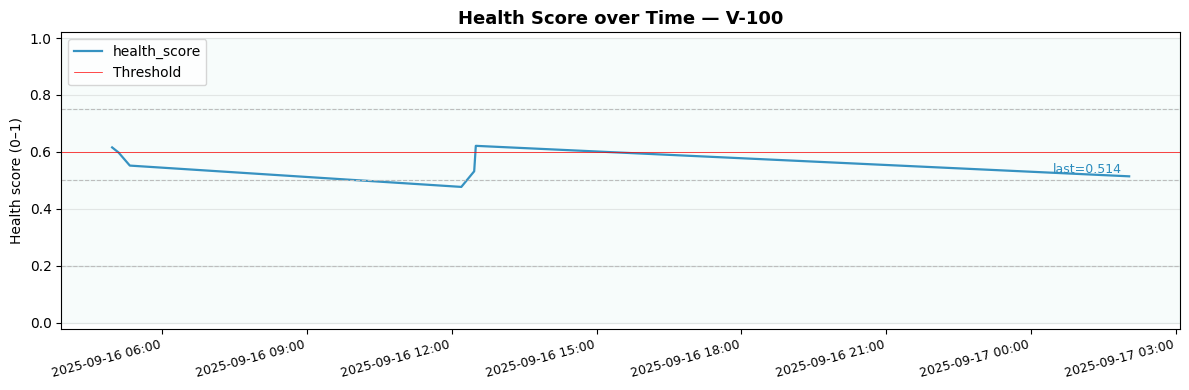

In [7]:

ts_raw = df["timestamp"]


ts = pd.to_datetime(ts_raw, errors="coerce", utc=False)


try:
    if pd.api.types.is_datetime64tz_dtype(ts):
        ts = ts.dt.tz_convert("UTC").dt.tz_localize(None)
    else:
        
        if ts.dt.tz is not None:
            ts = ts.dt.tz_convert("UTC").dt.tz_localize(None)
except Exception:
    
    ts = pd.to_datetime(ts_raw, errors="coerce", utc=True).dt.tz_localize(None)


df = df.copy()
df["timestamp"] = ts


if "composite_score" in df.columns:
    df["composite_score"] = pd.to_numeric(df["composite_score"], errors="coerce")
else:
    raise ValueError("input table missing 'composite_score' column")


if VEHICLE_ID is not None and "vehicle_id" in df.columns:
    df = df[df["vehicle_id"].astype(str) == str(VEHICLE_ID)]
if START is not None:
    df = df[df["timestamp"] >= pd.to_datetime(START, utc=False)]
if END is not None:
    df = df[df["timestamp"] <= pd.to_datetime(END, utc=False)]

df = df.sort_values("timestamp").reset_index(drop=True)
print("Rows after filters:", len(df))

if df.empty:
    print("No data to plot after filters — adjust VEHICLE_ID / START / END.")
else:
    
    RESAMPLE_RULE = "2T"   
    if RESAMPLE_RULE:
        series = df.set_index("timestamp")["composite_score"].resample(RESAMPLE_RULE).mean().interpolate(limit_direction="both")
        x_vals = series.index.to_pydatetime()   
        y_vals = series.values
    else:
        x_vals = df["timestamp"].dt.to_pydatetime()
        y_vals = df["composite_score"].values

    
    PALETTE = {
        "primary": "#2b8cbe",   # soft blue
        "accent":  "#7fcdbb",   # soft teal
        "muted":   "#bdbdbd"
    }
    SEVERITY_BANDS = [
        (0.0, 0.20, "normal"),
        (0.20, 0.50, "suspicious"),
        (0.50, 0.75, "anomaly"),
        (0.75, 1.00, "critical"),
    ]

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x_vals, y_vals, color=PALETTE["primary"], linewidth=1.6, label="health_score", alpha=0.95)

   
    for lo, hi, name in SEVERITY_BANDS:
        ax.axhspan(lo, hi, color=PALETTE["accent"], alpha=0.06)

   
    for thr in (0.20, 0.50, 0.75):
        ax.axhline(thr, color=PALETTE["muted"], linestyle="--", linewidth=0.8)

    if len(y_vals) > 0:
        ax.annotate(f"last={y_vals[-1]:.3f}", xy=(x_vals[-1], y_vals[-1]), xytext=(-5,0), textcoords="offset points",
                    ha="right", va="bottom", fontsize=9, color=PALETTE["primary"])
        
    ax.axhline(0.599999, color='r', linestyle="-", linewidth=0.5, label="Threshold")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", fontsize=9)

    ax.set_title(f"Health Score over Time{' — ' + str(VEHICLE_ID) if VEHICLE_ID else ''}", fontsize=13, fontweight="bold")
    ax.set_ylabel("Health score (0–1)")
    ax.set_ylim(-0.02, 1.02)
    ax.grid(axis="y", color=PALETTE["muted"], alpha=0.35)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_8024\3875001301.py:27: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(ts):


Rows to plot: 1999


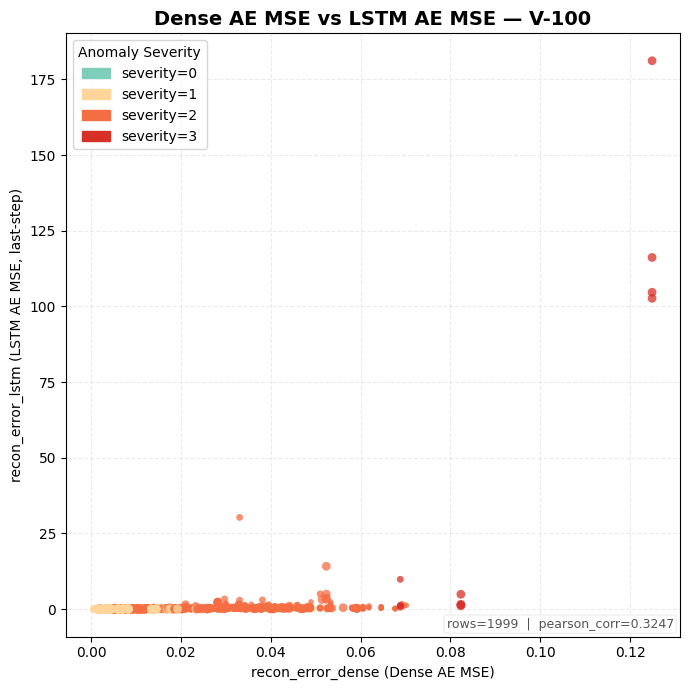

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


VEHICLE_ID = "V-100"   # or None
START = None           # e.g. "2025-10-01T00:00:00Z"
END   = None           # e.g. "2025-10-05T23:59:59Z"


required_cols = ["recon_error_dense", "recon_error_lstm", "anomaly_severity", "timestamp"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")


df2 = df.copy()
df2["recon_error_dense"] = pd.to_numeric(df2["recon_error_dense"], errors="coerce")
df2["recon_error_lstm"]  = pd.to_numeric(df2["recon_error_lstm"],  errors="coerce")
df2["anomaly_severity"]  = pd.to_numeric(df2["anomaly_severity"],  errors="coerce").fillna(0).astype(int)


try:
    ts = pd.to_datetime(df2["timestamp"], errors="coerce", utc=False)
    # handle tz-aware -> convert to UTC then drop tz
    if pd.api.types.is_datetime64tz_dtype(ts):
        ts = ts.dt.tz_convert("UTC").dt.tz_localize(None)
except Exception:
    ts = pd.to_datetime(df2["timestamp"], errors="coerce", utc=True).dt.tz_localize(None)
df2["timestamp"] = ts


if VEHICLE_ID is not None and "vehicle_id" in df2.columns:
    df2 = df2[df2["vehicle_id"].astype(str) == str(VEHICLE_ID)]
if START is not None:
    df2 = df2[df2["timestamp"] >= pd.to_datetime(START, utc=False)]
if END is not None:
    df2 = df2[df2["timestamp"] <= pd.to_datetime(END, utc=False)]


df2 = df2.dropna(subset=["recon_error_dense", "recon_error_lstm"]).sort_values("timestamp")
print("Rows to plot:", len(df2))

if df2.empty:
    print("No data to plot after filters.")
else:
    
    severity_colors = {0: "#7fcdbb", 1: "#ffd59a", 2: "#f46d43", 3: "#d73027"}
    colors = df2["anomaly_severity"].map(lambda s: severity_colors.get(int(s) if pd.notna(s) else 0, "#bdbdbd")).tolist()

    
    times = df2["timestamp"].astype("int64").values  # ns since epoch
    norm_times = (times - times.min()) / (times.max() - times.min() + 1e-9)
    sizes = (40 * (0.4 + 0.6 * norm_times)).clip(8, 120)  # between 8 and 120

    fig, ax = plt.subplots(figsize=(7,7))
    sc = ax.scatter(df2["recon_error_dense"], df2["recon_error_lstm"],
                    c=colors, s=sizes, alpha=0.75, edgecolors="none")

    
    ax.set_title(f"Dense AE MSE vs LSTM AE MSE{' — ' + str(VEHICLE_ID) if VEHICLE_ID else ''}", fontsize=14, weight="bold")
    ax.set_xlabel("recon_error_dense (Dense AE MSE)")
    ax.set_ylabel("recon_error_lstm (LSTM AE MSE, last-step)")

    
    ax.grid(alpha=0.25, linestyle="--")
    ax.set_axisbelow(True)

    
    try:
        corr = np.round(np.corrcoef(df2["recon_error_dense"].values, df2["recon_error_lstm"].values)[0,1], 4)
    except Exception:
        corr = None

    
    stats_txt = f"rows={len(df2)}"
    if corr is not None and not np.isnan(corr):
        stats_txt += f"  |  pearson_corr={corr}"
    ax.text(0.99, 0.01, stats_txt, transform=ax.transAxes, ha="right", va="bottom",
            fontsize=9, color="#555555", bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="#eee", alpha=0.9))

    
    handles = [mpatches.Patch(color=severity_colors[k], label=f"severity={k}") for k in sorted(severity_colors.keys())]
    ax.legend(handles=handles, title="Anomaly Severity", loc="upper left")

    
    ax.margins(0.05)

    plt.tight_layout()
    plt.show()


Rows to plot: 2000


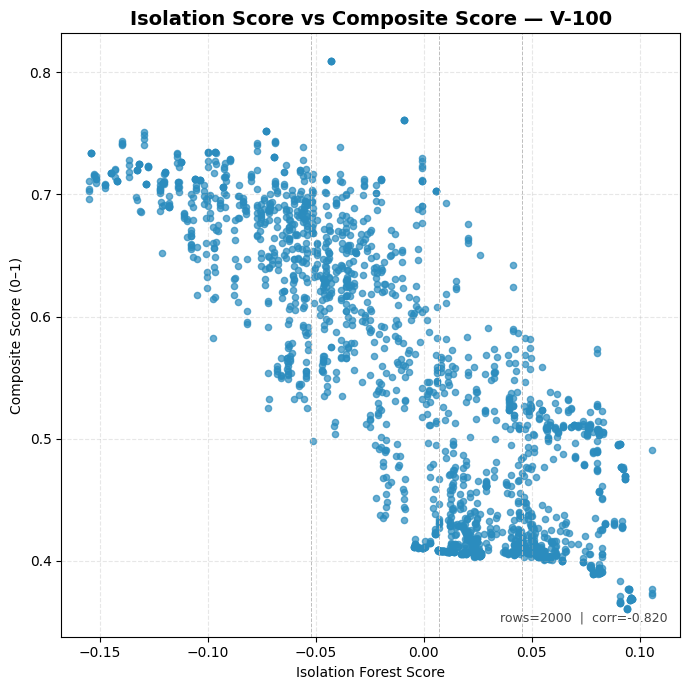

In [47]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

VEHICLE_ID = "V-100"
START = None
END = None

required_cols = ["isolation_score", "composite_score", "timestamp"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df3 = df.copy()
df3["isolation_score"] = pd.to_numeric(df3["isolation_score"], errors="coerce")
df3["composite_score"] = pd.to_numeric(df3["composite_score"], errors="coerce")
df3["timestamp"] = pd.to_datetime(df3["timestamp"], errors="coerce", utc=True).dt.tz_localize(None)

if VEHICLE_ID is not None and "vehicle_id" in df3.columns:
    df3 = df3[df3["vehicle_id"].astype(str) == str(VEHICLE_ID)]
if START is not None:
    df3 = df3[df3["timestamp"] >= pd.to_datetime(START)]
if END is not None:
    df3 = df3[df3["timestamp"] <= pd.to_datetime(END)]

df3 = df3.dropna(subset=["isolation_score", "composite_score"]).sort_values("timestamp")
print("Rows to plot:", len(df3))

if not df3.empty:
    fig, ax = plt.subplots(figsize=(7,7))
    scatter = ax.scatter(df3["isolation_score"], df3["composite_score"],
                         s=20, alpha=0.7, c="#2b8cbe")
    ax.set_title(f"Isolation Score vs Composite Score{' — ' + str(VEHICLE_ID) if VEHICLE_ID else ''}", fontsize=14, weight="bold")
    ax.set_xlabel("Isolation Forest Score")
    ax.set_ylabel("Composite Score (0–1)")
    ax.grid(alpha=0.3, linestyle="--")

    try:
        corr = np.corrcoef(df3["isolation_score"], df3["composite_score"])[0,1]
    except Exception:
        corr = np.nan

    ax.text(0.98, 0.02, f"rows={len(df3)}  |  corr={corr:.3f}",
            transform=ax.transAxes, ha="right", va="bottom", fontsize=9, color="#444")

    q25, q50, q75 = np.nanpercentile(df3["isolation_score"], [25, 50, 75])
    for v in [q25, q50, q75]:
        ax.axvline(v, color="#bdbdbd", linestyle="--", linewidth=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot after filters.")


Rows to plot: 2000


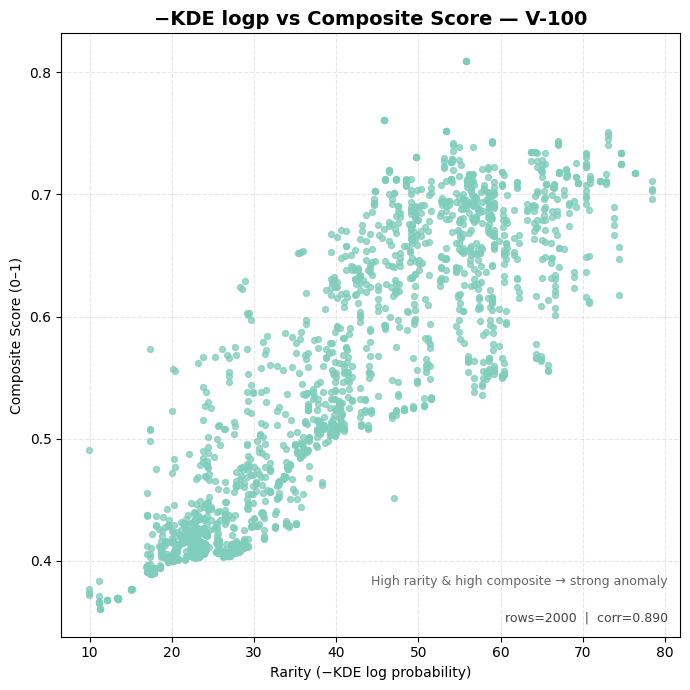

In [48]:
# Cell — −KDE logp vs Composite Score (rarity vs consensus scatter)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

VEHICLE_ID = "V-100"
START = None
END = None

required_cols = ["kde_logp", "composite_score", "timestamp"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df4 = df.copy()
df4["kde_logp"] = pd.to_numeric(df4["kde_logp"], errors="coerce")
df4["composite_score"] = pd.to_numeric(df4["composite_score"], errors="coerce")
df4["timestamp"] = pd.to_datetime(df4["timestamp"], errors="coerce", utc=True).dt.tz_localize(None)

if VEHICLE_ID is not None and "vehicle_id" in df4.columns:
    df4 = df4[df4["vehicle_id"].astype(str) == str(VEHICLE_ID)]
if START is not None:
    df4 = df4[df4["timestamp"] >= pd.to_datetime(START)]
if END is not None:
    df4 = df4[df4["timestamp"] <= pd.to_datetime(END)]

df4 = df4.dropna(subset=["kde_logp", "composite_score"]).sort_values("timestamp")
print("Rows to plot:", len(df4))

if not df4.empty:
    rarity = -df4["kde_logp"]
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(rarity, df4["composite_score"], s=18, alpha=0.75, c="#7fcdbb")
    ax.set_title(f"−KDE logp vs Composite Score{' — ' + str(VEHICLE_ID) if VEHICLE_ID else ''}", fontsize=14, weight="bold")
    ax.set_xlabel("Rarity (−KDE log probability)")
    ax.set_ylabel("Composite Score (0–1)")
    ax.grid(alpha=0.3, linestyle="--")

    try:
        corr = np.corrcoef(rarity, df4["composite_score"])[0,1]
    except Exception:
        corr = np.nan

    ax.text(0.98, 0.02, f"rows={len(df4)}  |  corr={corr:.3f}",
            transform=ax.transAxes, ha="right", va="bottom", fontsize=9, color="#444")

    ax.text(0.98, 0.08, "High rarity & high composite → strong anomaly",
            transform=ax.transAxes, ha="right", va="bottom", fontsize=9, color="#666")

    plt.tight_layout()
    plt.show()
else:
    print("No data to plot after filters.")


Rows to plot: 2000


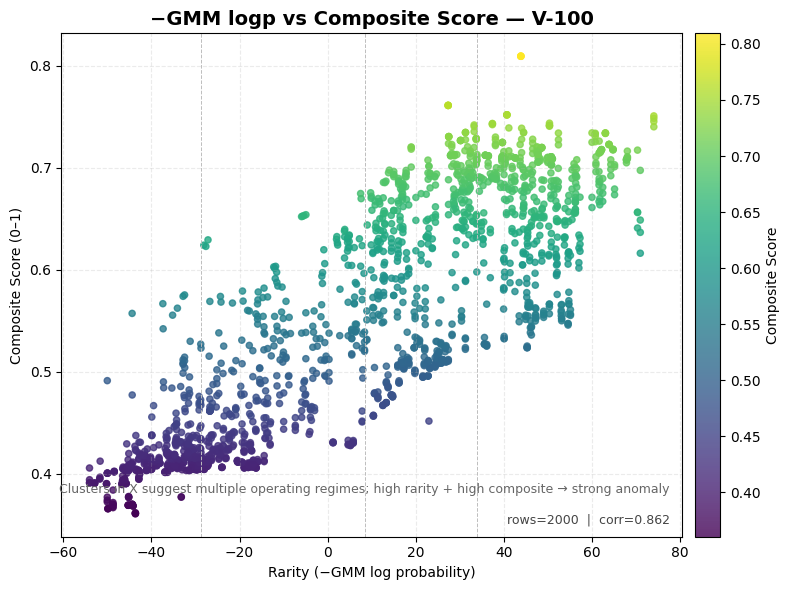

In [49]:
VEHICLE_ID = "V-100"
START = None
END = None

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

required_cols = ["gmm_logp", "composite_score", "timestamp"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df5 = df.copy()
df5["gmm_logp"] = pd.to_numeric(df5["gmm_logp"], errors="coerce")
df5["composite_score"] = pd.to_numeric(df5["composite_score"], errors="coerce")
df5["timestamp"] = pd.to_datetime(df5["timestamp"], errors="coerce", utc=True).dt.tz_localize(None)

if VEHICLE_ID is not None and "vehicle_id" in df5.columns:
    df5 = df5[df5["vehicle_id"].astype(str) == str(VEHICLE_ID)]
if START is not None:
    df5 = df5[df5["timestamp"] >= pd.to_datetime(START)]
if END is not None:
    df5 = df5[df5["timestamp"] <= pd.to_datetime(END)]

df5 = df5.dropna(subset=["gmm_logp", "composite_score"]).sort_values("timestamp")
print("Rows to plot:", len(df5))

if not df5.empty:
    rarity = -df5["gmm_logp"]
    fig, ax = plt.subplots(figsize=(8,6))
    sc = ax.scatter(rarity, df5["composite_score"], c=df5["composite_score"], cmap="viridis", s=20, alpha=0.8)
    ax.set_title(f"−GMM logp vs Composite Score{' — ' + str(VEHICLE_ID) if VEHICLE_ID else ''}", fontsize=14, weight="bold")
    ax.set_xlabel("Rarity (−GMM log probability)")
    ax.set_ylabel("Composite Score (0–1)")
    ax.grid(alpha=0.25, linestyle="--")

    try:
        corr = np.corrcoef(rarity, df5["composite_score"])[0,1]
    except Exception:
        corr = np.nan

    ax.text(0.98, 0.02, f"rows={len(df5)}  |  corr={corr:.3f}",
            transform=ax.transAxes, ha="right", va="bottom", fontsize=9, color="#444")

    cbar = plt.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
    cbar.set_label("Composite Score")

    q25, q50, q75 = np.nanpercentile(rarity, [25,50,75])
    for v in [q25, q50, q75]:
        ax.axvline(v, color="#bdbdbd", linestyle="--", linewidth=0.7)

    ax.text(0.98, 0.08, "Clusters in X suggest multiple operating regimes; high rarity + high composite → strong anomaly",
            transform=ax.transAxes, ha="right", va="bottom", fontsize=9, color="#666")

    plt.tight_layout()
    plt.show()
else:
    print("No data to plot after filters.")


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_8024\3434060392.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  per_min = is_anom.resample("1T").mean().fillna(0)


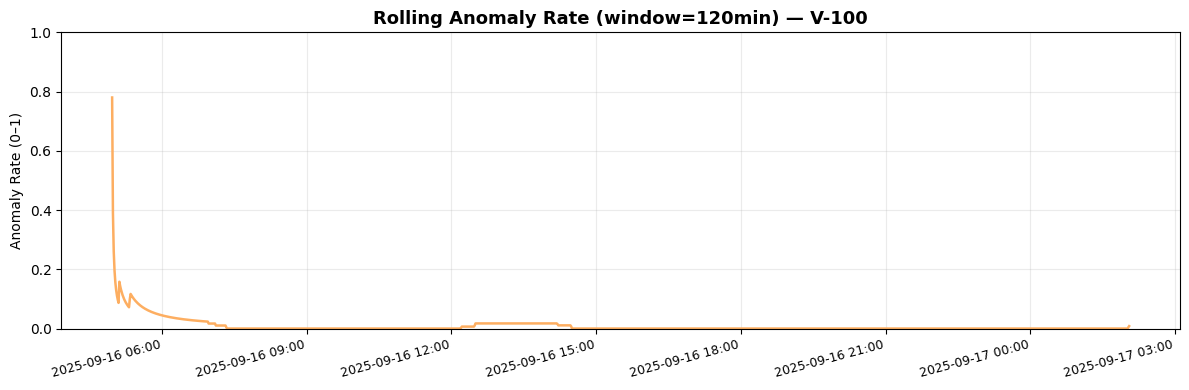

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

VEHICLE_ID = "V-100"
START = None
END = None
ROLLING_WINDOW = "120min"

required_cols = ["timestamp", "anomaly_severity"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df6 = df.copy()
df6["timestamp"] = pd.to_datetime(df6["timestamp"], errors="coerce", utc=True).dt.tz_convert("UTC").dt.tz_localize(None)
df6["anomaly_severity"] = pd.to_numeric(df6["anomaly_severity"], errors="coerce").fillna(0).astype(int)

if VEHICLE_ID is not None and "vehicle_id" in df6.columns:
    df6 = df6[df6["vehicle_id"].astype(str) == str(VEHICLE_ID)]
if START is not None:
    df6 = df6[df6["timestamp"] >= pd.to_datetime(START)]
if END is not None:
    df6 = df6[df6["timestamp"] <= pd.to_datetime(END)]

df6 = df6.sort_values("timestamp").reset_index(drop=True)
if df6.empty:
    print("No data to plot after filters.")
else:
    df6 = df6.set_index("timestamp")
    is_anom = (df6["anomaly_severity"] >= 2).astype(float)
    per_min = is_anom.resample("1T").mean().fillna(0)
    rolling = per_min.rolling(ROLLING_WINDOW).mean()

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(rolling.index.to_pydatetime(), rolling.values, linewidth=1.8, color="#fdae61")
    ax.set_title(f"Rolling Anomaly Rate (window={ROLLING_WINDOW}){' — ' + str(VEHICLE_ID) if VEHICLE_ID else ''}", fontsize=13, weight="bold")
    ax.set_ylabel("Anomaly Rate (0–1)")
    ax.set_ylim(0, 1.0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", fontsize=9)
    ax.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


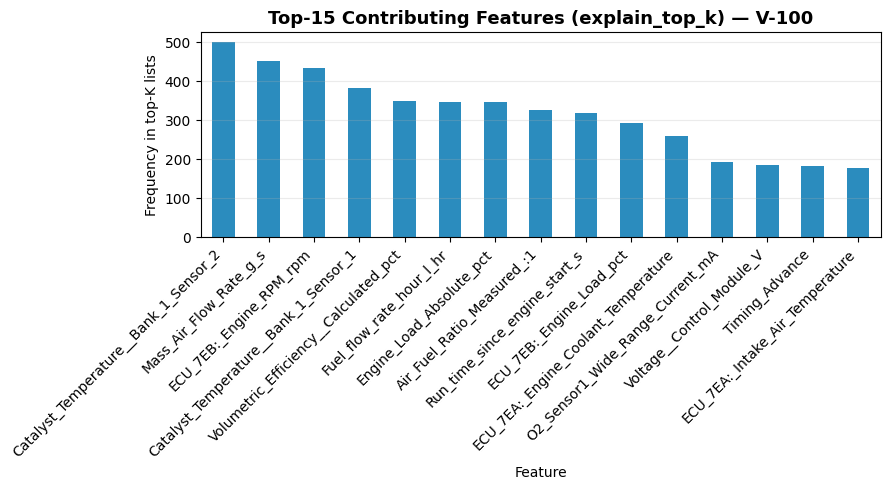

In [54]:
VEHICLE_ID = "V-100"
START = None
END = None
TOPN = 15

import json, numpy as np, pandas as pd, matplotlib.pyplot as plt

df_p = df.copy()
if "timestamp" in df_p.columns:
    df_p["timestamp"] = pd.to_datetime(df_p["timestamp"], errors="coerce", utc=True)

if VEHICLE_ID is not None and "vehicle_id" in df_p.columns:
    df_p = df_p[df_p["vehicle_id"].astype(str) == str(VEHICLE_ID)]
if START is not None:
    df_p = df_p[df_p["timestamp"] >= pd.to_datetime(START, utc=True)]
if END is not None:
    df_p = df_p[df_p["timestamp"] <= pd.to_datetime(END, utc=True)]
df_p = df_p.reset_index(drop=True)

def normalize_explain(v):
    if v is None: 
        return []
    if isinstance(v, np.ndarray):
        try:
            lst = v.tolist()
        except Exception:
            lst = list(v)
        v = lst
    if isinstance(v, (list, tuple)):
        out = []
        for item in v:
            if isinstance(item, dict):
                out.append(item)
            else:
                try:
                    if isinstance(item, str):
                        parsed = json.loads(item)
                        if isinstance(parsed, dict):
                            out.append(parsed)
                        elif isinstance(parsed, list):
                            for p in parsed:
                                if isinstance(p, dict):
                                    out.append(p)
                    else:
                        # try to coerce
                        parsed = json.loads(str(item))
                        if isinstance(parsed, dict):
                            out.append(parsed)
                except Exception:
                    continue
        return out
    if isinstance(v, dict):
        return [v]
    if isinstance(v, str):
        s = v.strip()
        for _ in range(2):
            try:
                s = json.loads(s)
            except Exception:
                break
        if isinstance(s, dict):
            return [s]
        if isinstance(s, list):
            res = []
            for item in s:
                if isinstance(item, dict):
                    res.append(item)
            return res
    try:
        parsed = json.loads(str(v))
        if isinstance(parsed, dict):
            return [parsed]
        if isinstance(parsed, list):
            return [p for p in parsed if isinstance(p, dict)]
    except Exception:
        return []
    return []

if "explain_top_k" not in df_p.columns:
    raise ValueError("explain_top_k column missing")

counts = {}
for val in df_p["explain_top_k"].astype(object):
    items = normalize_explain(val)
    for it in items:
        feat = it.get("feature") if isinstance(it, dict) else None
        if not feat:
            continue
        feat = str(feat)
        counts[feat] = counts.get(feat, 0) + 1

if not counts:
    print("No explain_top_k data available after robust parsing.")
else:
    s = pd.Series(counts).sort_values(ascending=False).head(TOPN)
    fig, ax = plt.subplots(figsize=(max(8, 0.6*len(s)), 5))
    s.plot(kind="bar", color="#2b8cbe", ax=ax)
    ax.set_title(f"Top-{TOPN} Contributing Features (explain_top_k){' — ' + str(VEHICLE_ID) if VEHICLE_ID else ''}", fontsize=13, weight="bold")
    ax.set_xlabel("Feature")
    ax.set_ylabel("Frequency in top-K lists")
    ax.grid(axis="y", alpha=0.25)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_8024\2211952132.py:118: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pivot = tall.groupby([pd.Grouper(freq=TIME_BIN, key="timestamp"), "feature"])["value"].mean().reset_index().pivot(index="timestamp", columns="feature", values="value")


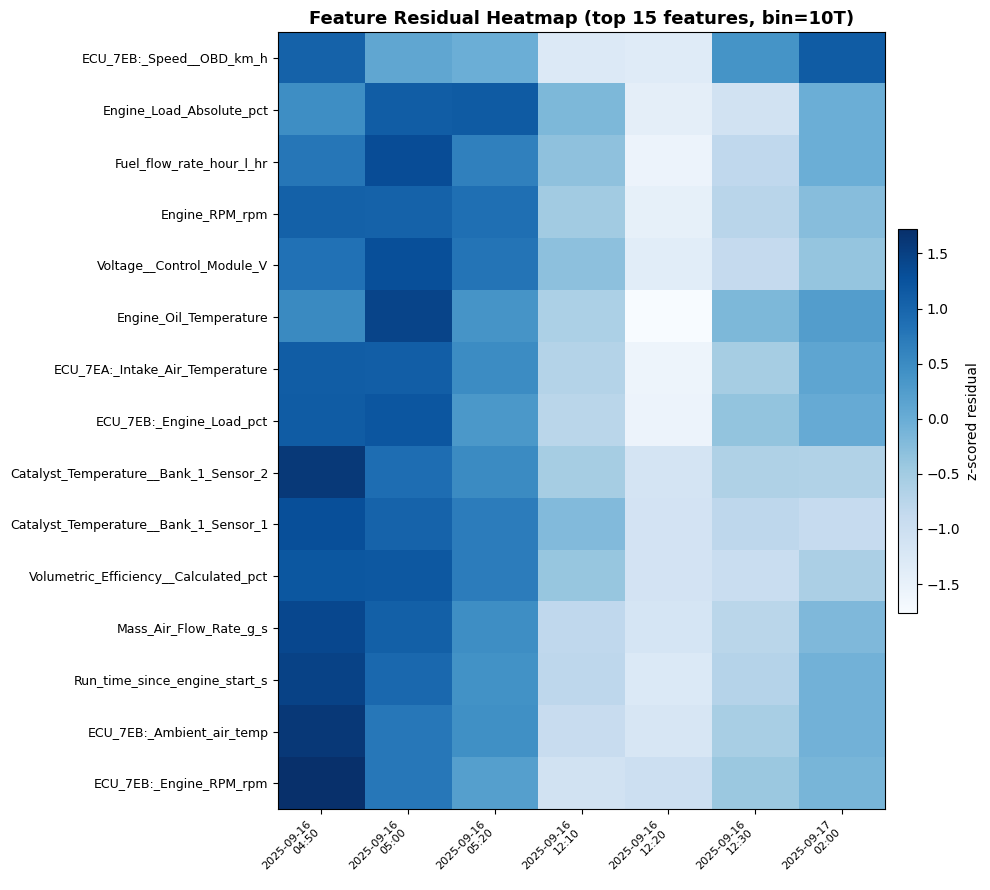

In [59]:
VEHICLE_ID = "V-100"
START = None
END = None
TIME_BIN = "10T"
TOPN = 15
SMOOTH_WINDOW = 3
NORMALIZE = True
CLUSTER = True
MAX_X_TICKS = 12

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.cluster.hierarchy import linkage, leaves_list

dfh = df.copy()
if "timestamp" in dfh.columns:
    dfh["timestamp"] = pd.to_datetime(dfh["timestamp"], errors="coerce", utc=True).dt.tz_convert("UTC").dt.tz_localize(None)
if VEHICLE_ID is not None and "vehicle_id" in dfh.columns:
    dfh = dfh[dfh["vehicle_id"].astype(str) == str(VEHICLE_ID)]
if START is not None:
    dfh = dfh[dfh["timestamp"] >= pd.to_datetime(START, utc=True)]
if END is not None:
    dfh = dfh[dfh["timestamp"] <= pd.to_datetime(END, utc=True)]
dfh = dfh.sort_values("timestamp").reset_index(drop=True)

if "dense_per_feature_error" not in dfh.columns:
    raise ValueError("dense_per_feature_error column missing")

def parse_dense_val(val):
    if val is None: return None
    if isinstance(val, dict):
        return {str(k): float(v) if v is not None else np.nan for k, v in val.items()}
    if isinstance(val, np.ndarray):
        try: val = val.tolist()
        except Exception: pass
    if isinstance(val, (list, tuple)):
        out = {}
        for item in val:
            if item is None: continue
            if isinstance(item, dict):
                if "feature" in item and ("contribution" in item or "value" in item):
                    feat = str(item.get("feature"))
                    v = item.get("contribution", item.get("value", None))
                    try: out[feat] = float(v) if v is not None else np.nan
                    except Exception: out[feat] = np.nan
                elif len(item) == 1:
                    k, vv = next(iter(item.items()))
                    try: out[str(k)] = float(vv) if vv is not None else np.nan
                    except Exception: out[str(k)] = np.nan
                else:
                    for k2, v2 in item.items():
                        try: out[str(k2)] = float(v2) if v2 is not None else np.nan
                        except Exception: out[str(k2)] = np.nan
            elif isinstance(item, (list, tuple)) and len(item) >= 2:
                try:
                    feat = str(item[0]); v = item[1]; out[feat] = float(v) if v is not None else np.nan
                except Exception:
                    continue
            else:
                if isinstance(item, str):
                    s = item.strip()
                    try:
                        parsed = json.loads(s)
                        if isinstance(parsed, dict):
                            for k3, v3 in parsed.items():
                                try: out[str(k3)] = float(v3) if v3 is not None else np.nan
                                except Exception: out[str(k3)] = np.nan
                        elif isinstance(parsed, list):
                            for it in parsed:
                                if isinstance(it, dict) and "feature" in it and ("contribution" in it or "value" in it):
                                    feat = str(it.get("feature")); v = it.get("contribution", it.get("value", None))
                                    try: out[feat] = float(v) if v is not None else np.nan
                                    except Exception: out[feat] = np.nan
                    except Exception:
                        continue
        return out if out else None
    if isinstance(val, str):
        s = val.strip()
        for _ in range(2):
            try:
                s = json.loads(s)
            except Exception:
                break
        if isinstance(s, dict): return parse_dense_val(s)
        if isinstance(s, (list, tuple)): return parse_dense_val(list(s))
        try:
            if s.startswith("[") or s.startswith("{"):
                parsed = eval(s, {"__builtins__": None}, {})
                return parse_dense_val(parsed)
        except Exception:
            pass
    return None

rows = []
for _, r in dfh.iterrows():
    ts = r["timestamp"]; val = r["dense_per_feature_error"]
    parsed = parse_dense_val(val)
    if parsed is None: continue
    for feat, v in parsed.items():
        try: rows.append((ts, str(feat), float(v) if v is not None else np.nan))
        except Exception: rows.append((ts, str(feat), np.nan))

if not rows:
    raise RuntimeError("No dense_per_feature_error parsed for any row")

tall = pd.DataFrame(rows, columns=["timestamp", "feature", "value"]).dropna(subset=["timestamp"]).reset_index(drop=True)
tall["value"] = pd.to_numeric(tall["value"], errors="coerce")

agg = tall.set_index("timestamp").groupby("feature")["value"].agg(["count","mean","std"])
if agg.empty:
    raise RuntimeError("Empty aggregation on parsed feature values")

top_features = agg.sort_values("std", ascending=False).head(TOPN).index.tolist()
tall = tall[tall["feature"].isin(top_features)]

pivot = tall.groupby([pd.Grouper(freq=TIME_BIN, key="timestamp"), "feature"])["value"].mean().reset_index().pivot(index="timestamp", columns="feature", values="value")
pivot = pivot.sort_index().fillna(0.0)

if SMOOTH_WINDOW and SMOOTH_WINDOW > 1:
    pivot = pivot.rolling(SMOOTH_WINDOW, min_periods=1).mean()

if NORMALIZE:
    pivot = (pivot - pivot.mean()) / (pivot.std().replace(0, 1))

if CLUSTER:
    try:
        feat_matrix = pivot.fillna(0).T.values
        if feat_matrix.shape[0] > 1:
            Z = linkage(feat_matrix, method="ward", metric="euclidean")
            order = leaves_list(Z)
            ordered_features = pivot.columns.tolist()
            pivot = pivot.iloc[:, order]
    except Exception:
        pass

pivot = pivot.fillna(0)
n_time, n_feat = pivot.shape
fig_w = max(10, min(40, 0.6 * n_time))
fig_h = max(6, 0.6 * n_feat)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
im = ax.imshow(pivot.T.values, aspect="auto", interpolation="nearest", cmap="Blues")
cbar = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("z-scored residual" if NORMALIZE else "residual")

yticks = np.arange(len(pivot.columns))
ax.set_yticks(yticks)
ax.set_yticklabels(pivot.columns.tolist(), fontsize=9)
if n_time <= MAX_X_TICKS:
    xt_idx = np.arange(n_time)
    xlabels = [ts.strftime("%Y-%m-%d\n%H:%M") for ts in pivot.index.to_pydatetime()]
    ax.set_xticks(xt_idx)
    ax.set_xticklabels(xlabels, rotation=45, ha="right", fontsize=8)
else:
    xt_pos = np.linspace(0, n_time - 1, min(MAX_X_TICKS, n_time)).astype(int)
    pick_times = pivot.index.to_pydatetime()
    labels = [pick_times[i].strftime("%Y-%m-%d\n%H:%M") for i in xt_pos]
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(xt_pos)
    ax_top.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
    ax_top.set_xlabel("timestamp")

ax.set_title(f"Feature Residual Heatmap (top {n_feat} features, bin={TIME_BIN})", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()


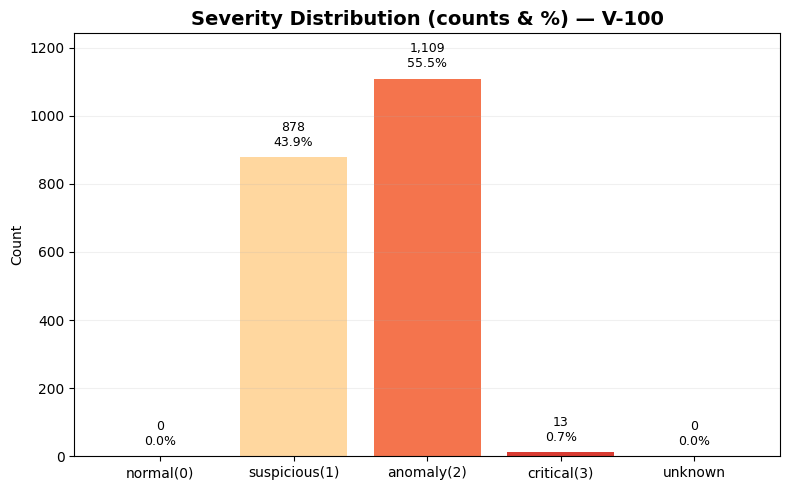

In [61]:
VEHICLE_ID = "V-100"
START = None
END = None
PALETTE = {0:"#7fcdbb",1:"#ffd59a",2:"#f46d43",3:"#d73027", "unknown":"#bdbdbd"}

import numpy as np, pandas as pd, matplotlib.pyplot as plt

dfs = df.copy()
if "timestamp" in dfs.columns:
    dfs["timestamp"] = pd.to_datetime(dfs["timestamp"], errors="coerce", utc=True).dt.tz_convert("UTC").dt.tz_localize(None)
if VEHICLE_ID is not None and "vehicle_id" in dfs.columns:
    dfs = dfs[dfs["vehicle_id"].astype(str) == str(VEHICLE_ID)]
if START is not None:
    dfs = dfs[dfs["timestamp"] >= pd.to_datetime(START, utc=True)]
if END is not None:
    dfs = dfs[dfs["timestamp"] <= pd.to_datetime(END, utc=True)]
dfs = dfs.reset_index(drop=True)

if "anomaly_severity" not in dfs.columns:
    raise ValueError("anomaly_severity column missing")

ser = pd.to_numeric(dfs["anomaly_severity"], errors="coerce")
bins = [0,1,2,3]
labels = [0,1,2,3]
counts = {lab: int(((ser==lab).sum())) for lab in labels}
unknown_count = int(ser.isna().sum())
total = sum(counts.values()) + unknown_count
if total == 0:
    print("No rows to plot after filtering.")
else:
    pct = {k: (v/total*100.0) for k,v in counts.items()}
    pct_unknown = (unknown_count/total*100.0)

    x = ["normal(0)","suspicious(1)","anomaly(2)","critical(3)","unknown"]
    vals = [counts[0], counts[1], counts[2], counts[3], unknown_count]
    colors = [PALETTE.get(0), PALETTE.get(1), PALETTE.get(2), PALETTE.get(3), PALETTE.get("unknown")]

    fig, ax = plt.subplots(figsize=(8,5))
    bars = ax.bar(x, vals, color=colors, alpha=0.95)
    ax.set_title(f"Severity Distribution (counts & %) {'— ' + str(VEHICLE_ID) if VEHICLE_ID else ''}", fontsize=14, fontweight="bold")
    ax.set_ylabel("Count")
    ax.grid(axis="y", alpha=0.18)

    for i, b in enumerate(bars):
        h = b.get_height()
        if i < 4:
            percentage = pct[labels[i]]
            txt = f"{h:,}\n{percentage:.1f}%"
        else:
            txt = f"{h:,}\n{pct_unknown:.1f}%"
        ax.annotate(txt, xy=(b.get_x() + b.get_width()/2, h), xytext=(0,6), textcoords="offset points", ha="center", va="bottom", fontsize=9)

    ax.set_ylim(0, max(vals)*1.12 if max(vals)>0 else 1)
    plt.tight_layout()
    plt.show()


C:\Users\ishaan256185\AppData\Local\Temp\ipykernel_8024\2699708284.py:61: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  s = df_l.set_index("window_end_ts")["reconstruction_error"].resample(RESAMPLE_RULE).mean().interpolate(limit_direction="both")


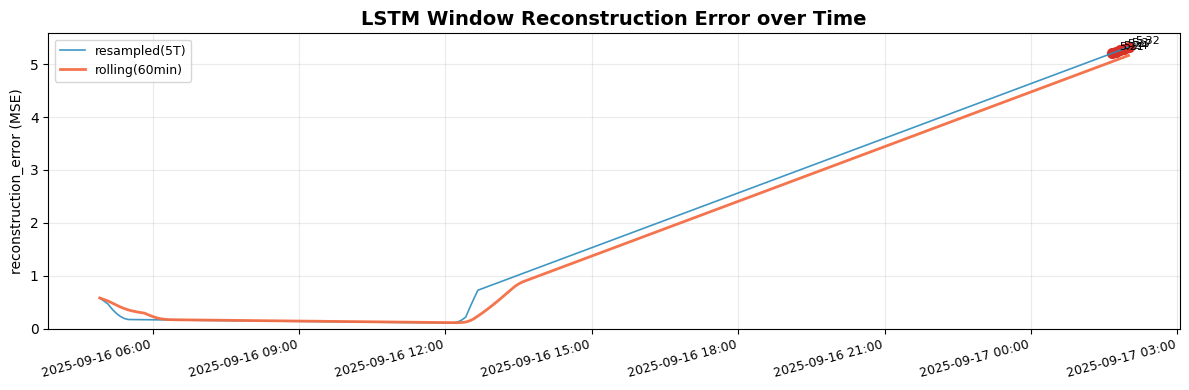

In [62]:
# Cell — Window Reconstruction Error Time Series (per vehicle)

import os, json
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.dates as mdates
from datetime import datetime, timezone

LSTM_WIN_PATH = r"C:\engine_module_pipeline\infer_stage\delta\engine_module_lstm_windows"
VEHICLE_ID = None
START = None
END = None
RESAMPLE_RULE = "5T"
ROLL_WINDOW = "60min"
SMOOTH_WINDOW = 3

p = Path(LSTM_WIN_PATH)
if p.is_dir() and (p / "_delta_log").exists():
    try:
        from deltalake import DeltaTable
        dt = DeltaTable(str(p))
        df_l = dt.to_pandas()
    except Exception:
        files = list(p.glob("*.parquet"))
        if files:
            df_l = pd.concat([pd.read_parquet(str(f)) for f in files], ignore_index=True)
        else:
            raise RuntimeError(f"Can't read Delta path: {p}")
elif p.is_file() and p.suffix.lower() in (".parquet", ".pq"):
    df_l = pd.read_parquet(str(p))
elif p.is_file() and p.suffix.lower() == ".csv":
    df_l = pd.read_csv(str(p))
else:
    raise FileNotFoundError(f"LSTM window path not found: {LSTM_WIN_PATH}")

if "window_end_ts" in df_l.columns:
    df_l["window_end_ts"] = pd.to_datetime(df_l["window_end_ts"], errors="coerce", utc=True).dt.tz_convert("UTC").dt.tz_localize(None)
elif "window_start_ts" in df_l.columns:
    df_l["window_end_ts"] = pd.to_datetime(df_l["window_start_ts"], errors="coerce", utc=True).dt.tz_convert("UTC").dt.tz_localize(None)
else:
    raise ValueError("No window_start_ts or window_end_ts column found in LSTM windows table")

if "reconstruction_error" not in df_l.columns:
    raise ValueError("reconstruction_error column missing in LSTM windows table")
df_l["reconstruction_error"] = pd.to_numeric(df_l["reconstruction_error"], errors="coerce")

if VEHICLE_ID is not None and "inference_run_id" in df_l.columns and "vehicle_id" not in df_l.columns:
    pass

if VEHICLE_ID is not None and "vehicle_id" in df_l.columns:
    df_l = df_l[df_l["vehicle_id"].astype(str) == str(VEHICLE_ID)]
if START is not None:
    df_l = df_l[df_l["window_end_ts"] >= pd.to_datetime(START)]
if END is not None:
    df_l = df_l[df_l["window_end_ts"] <= pd.to_datetime(END)]

df_l = df_l.sort_values("window_end_ts").reset_index(drop=True)
if df_l.empty:
    print("No LSTM windows after filters.")
else:
    s = df_l.set_index("window_end_ts")["reconstruction_error"].resample(RESAMPLE_RULE).mean().interpolate(limit_direction="both")
    if SMOOTH_WINDOW and SMOOTH_WINDOW > 1:
        s = s.rolling(SMOOTH_WINDOW, min_periods=1).mean()
    roll = s.rolling(ROLL_WINDOW).mean()

    fig, ax = plt.subplots(figsize=(12,4))
    x = s.index.to_pydatetime()
    ax.plot(x, s.values, label=f"resampled({RESAMPLE_RULE})", color="#2b8cbe", linewidth=1.2, alpha=0.9)
    ax.plot(x, roll.values, label=f"rolling({ROLL_WINDOW})", color="#f46d43", linewidth=2.0, alpha=0.95)
    ax.set_title(f"LSTM Window Reconstruction Error over Time{' — ' + str(VEHICLE_ID) if VEHICLE_ID else ''}", fontsize=14, fontweight="bold")
    ax.set_ylabel("reconstruction_error (MSE)")
    ax.set_ylim(bottom=0)
    ax.grid(alpha=0.25)

    if len(s) > 0:
        topk = s.dropna().sort_values(ascending=False).head(5)
        for ts, val in topk.items():
            ax.scatter(ts.to_pydatetime(), val, s=50, color="#d73027")
            ax.annotate(f"{val:.3g}", xy=(ts.to_pydatetime(), val), xytext=(5,2), textcoords="offset points", fontsize=8)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", fontsize=9)
    ax.legend(loc="upper left", fontsize=9)
    plt.tight_layout()
    plt.show()
